In [77]:
from binance.client import Client
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross, resample_apply, plot_heatmaps
from skopt.plots import plot_objective
import scipy.optimize as spopt
from pykalman import KalmanFilter
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
# DATA LOAD AND PROCESSING

In [81]:
api_key = 'knlZCBMnLPX0S2HQrn8hZDeQseyvjcGqSLzhnCbuVbiFj6VZNXvpD9snD7P2kc9I'
api_secret = 'aMdB68Omz8RGW8tdlW2AIg2GFzVDmL5bkMhhcvernn6YikJZlSs62kLTB3ZP10oU'

In [82]:
client = Client(api_key, api_secret)

In [83]:
# List of pairs qouted in Tether
symbols = ['ETHBTC']

In [84]:
interval = Client.KLINE_INTERVAL_15MINUTE
start_date = '2023-01-01'
end_date = '2023-12-31'

In [85]:
def load_data(symbol, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbol
    """
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades',
               'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df

In [86]:
def load_data_for_symbols(symbols, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbols batch
    """
    data = {}
    for symbol in symbols:
        df = load_data(symbol, interval, start_date, end_date)
        data[symbol] = df
    return data

In [87]:
symbols_df = load_data_for_symbols(symbols, interval, start_date, end_date)

In [88]:
print(symbols_df.keys())

dict_keys(['ETHBTC'])


In [89]:
#print(symbols_df.items())

In [90]:
print(symbols_df['ETHBTC'].head(1))

                Open      High       Low     Close    Volume
timestamp                                                   
2023-01-01  0.072299  0.072356  0.072299  0.072306  495.7506


In [91]:
symbol = 'ETHBTC'

In [92]:
df = symbols_df[symbol]

In [93]:
#df.info()

In [94]:
df.head(1)

,Open,High,Low,Close,Volume
timestamp,,,,,
2023-01-01,0.072299,0.072356,0.072299,0.072306,495.7506


In [95]:
# TECHNICAL INDICATORS

In [96]:
def keltner_channel(data, period=12, atr_multiplier=2):
    """
    Keltner Channel Indicator (ATR volatility range)
    """
    true_range = data['High'] - data['Low']
    # print(len(true_range))
    previous_close = pd.Series(data['Close']).shift(1)
    
    high_minus_previous_close = abs(data['High'] - previous_close)
    low_minus_previous_close = abs(data['Low'] - previous_close)

    true_range = np.maximum.reduce([true_range, high_minus_previous_close, low_minus_previous_close])

    true_range_series = pd.Series(true_range, index=data.index)
    # print(len(true_range_series))
    
    true_range_series = pd.Series(data['High']) - pd.Series(data['Low'])
    # print(len(true_range_series))
    # Compute ATR
    atr = true_range_series.rolling(period, min_periods=1).mean()
    # print('atr', len(atr))
    # Compute Keltner Channel range
    mean = pd.Series(data['Close']).rolling(period).mean()
    upper_channel =  mean + atr * atr_multiplier
    lower_channel = mean - atr * atr_multiplier
    #print(len(upper_channel))
    return pd.DataFrame({'upper': upper_channel, 'lower': lower_channel, 'mean': mean})

In [97]:
enable_echo = True

In [98]:
def log(*args, **kwargs):
    if enable_echo:
        print(*args, **kwargs)

In [99]:
# STRATEGIES

In [100]:
class KelnerChannelRVStrategy(Strategy):
    """
    Simple RV trading system based on Keltner channel.
    Entry Logic: Price is outside a channel's border
    Exit Logic: Price returned to the channel's mean
    Position Management: Stop Loss, Take Profit, Breakeven
    """
    # Logic
    
    # Input parameters for Keltner Channels Spread
    kch_period = 18
    kch_mult = 3

    # Exit trigger
    exit_trig_is_on = 0
    # stop_loss
    stop_loss_is_on = 1
    # Extremum search lookback
    stop_loss_lookback = 4
    stop_loss_pct = 0.0
    # Break even from Entry price
    break_even_is_on = 1
    break_even_pct = 0.001
    # Dynamic TP
    profit_target_is_on = 0
    profit_target_dyn_ratio = 1

    def init(self):
        super().init()
        # Compute fast and slow Kelner Channels
        # log(type(self.data.Close))
        self.kch_channel = self.I(keltner_channel, self.data, self.kch_period, self.kch_mult)
        
        self.kch_upborder = self.kch_channel[0]
        self.kch_downborder = self.kch_channel[1]
        self.kch_mean = self.kch_channel[2]
        
        #log('up fast', self.kch_upborder)
        #log('dn fast', self.kch_downborder)
        
        # Position varaibles
        self.stop_loss = 0
        self.profit_target = 0
        self.be_level = 0
        self.entry_price = 0
                
    def next(self):
        # A Position is opened        
        if self.position:
            # log(self.position.size)
            # Check Exit triggers
            exit_trigger = False
            sign = 1 if self.position.is_long else -1
            side = 'long' if self.position.is_long else 'short'
            # Check Exit trigger
            exit_trigger = (self.data.Close[-1] - self.kch_mean[-1]) * sign > 0 or \
                    self.stop_loss > 0 and (self.data.Close[-1] - self.stop_loss) * sign < 0  or \
                    self.profit_target > 0 and (self.data.Close[-1] - self.profit_target) * sign > 0            
            if exit_trigger:
                log(side, 'close trigger:', 'mean', self.kch_mean[-1], self.data.Close[-1])
                # Exit action
                log('close the position:', self.position.size, self.data.index[-1], self.data.Close[-1])
                log('-' * 90)
                self.position.close()
            # Check Breakeven trigger
            elif self.break_even_is_on == 1 and self.be_level == 0:                
                thresh = self.entry_price * (1 + self.break_even_pct * sign)
                if (self.data.Close[-1] - thresh) * sign > 0:
                    self.be_level = thresh   
                    self.stop_loss = thresh    
                log('be level:', self.data.index[-1], self.entry_price, self.break_even_pct, '->', thresh, self.data.Close[-1])
                 
        # Is Flat
        #log(self.position, type(self.position))
        if self.position.size == 0:
            # log('position is flat')
            # Long trigger
            if self.data.Close[-1] < self.kch_downborder[-1]:
                log('long trigger', self.data.index[-1], 'c', self.data.Close[-1], 'o', self.data.Open[-1], 'dn', self.kch_downborder[-1])
                log('open long', self.data.Close[-1])
                self.buy()
                self.entry_price = self.data.Close[-1]
                self.be_level = 0
                # Set initial Stop Loss and Profit Target
                if self.stop_loss_is_on == 1:
                    min_level = pd.Series(self.data.Low).rolling(window=self.stop_loss_lookback).min().iloc[-1]
                    #log(min_level)                 
                    self.stop_loss = min_level * (1 - self.stop_loss_pct)
                #log('sl', self.stop_loss)
                if self.profit_target_is_on == 1:
                    self.profit_target = self.entry_price + abs(self.entry_price - self.stop_loss) * self.profit_target_dyn_ratio
                log(f'intial sl {self.stop_loss} and tp {self.profit_target}')
            # Short trigger
            elif self.data.Close[-1] > self.kch_upborder[-1]:
                log('short trigger', self.data.index[-1], 'c', self.data.Close[-1], 'o', self.data.Open[-1], 'up',  self.kch_upborder[-1])
                log('open short', self.data.Close[-1])
                self.sell()
                self.entry_price = self.data.Close[-1]
                self.be_level = 0
                 # Set initial Stop Loss and Profit Target
                if self.stop_loss_is_on == 1:
                    max_level = pd.Series(self.data.High).rolling(window=self.stop_loss_lookback).max().iloc[-1]
                    #log(max_level)
                    self.stop_loss = max_level * (1 + self.stop_loss_pct)
                    #log('sl', self.stop_loss)
                if self.profit_target_is_on == 1:
                    self.profit_target = self.entry_price - abs(self.entry_price - self.stop_loss) * self.profit_target_dyn_ratio
                log(f'intial sl {self.stop_loss} and tp {self.profit_target}')
                

In [101]:
fee_per_turn = 0.002

In [102]:
bt = Backtest(df, KelnerChannelRVStrategy,cash=1, commission=fee_per_turn, trade_on_close=True,
              hedging=False, exclusive_orders=True)
stats = bt.run()

long trigger 2023-01-01 13:30:00 c 0.072205 o 0.072275 dn 0.07220783333333333
open long 0.072205
intial sl 0.072173 and tp 0
be level: 2023-01-01 13:45:00 0.072205 0.001 -> 0.072277205 0.072229
be level: 2023-01-01 14:00:00 0.072205 0.001 -> 0.072277205 0.072223
be level: 2023-01-01 14:15:00 0.072205 0.001 -> 0.072277205 0.072219
be level: 2023-01-01 14:30:00 0.072205 0.001 -> 0.072277205 0.072203
be level: 2023-01-01 14:45:00 0.072205 0.001 -> 0.072277205 0.072203
be level: 2023-01-01 15:00:00 0.072205 0.001 -> 0.072277205 0.072224
be level: 2023-01-01 15:15:00 0.072205 0.001 -> 0.072277205 0.072249
long close trigger: mean 0.07225433333333334 0.072275
close the position: 13 2023-01-01 15:30:00 0.072275
------------------------------------------------------------------------------------------
short trigger 2023-01-01 17:15:00 c 0.072419 o 0.072307 up 0.0723855
open short 0.072419
intial sl 0.0725 and tp 0
be level: 2023-01-01 17:30:00 0.072419 0.001 -> 0.072346581 0.072426
be level: 2

In [103]:
stats

Start                     2023-01-01 00:00:00
End                       2023-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                   15.789926
Equity Final [$]                     0.150258
Equity Peak [$]                           1.0
Return [%]                         -84.974183
Buy & Hold Return [%]              -24.791857
Return (Ann.) [%]                  -84.943404
Volatility (Ann.) [%]                2.137485
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -85.131559
Avg. Drawdown [%]                  -85.131559
Max. Drawdown Duration      363 days 10:30:00
Avg. Drawdown Duration      363 days 10:30:00
# Trades                                 1043
Win Rate [%]                        16.682646
Best Trade [%]                       2.684468
Worst Trade [%]                     -2.591293
Avg. Trade [%]                    

In [104]:
# Let's optimize Trading system's inputs (backtesting.py package)

In [105]:
# https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize

In [106]:
# OPTIMIZERS

In [107]:
def optimize_fitness(bt, fitness, tries):
    """
    Grid optimizer
    """
    global enable_echo
    enable_echo = False
    stats, heatmap = bt.optimize(
    kch_period=range(6, 18, 3),
    kch_mult=[2.5, 3.0, 3.5, 4.0],
    maximize=fitness,
    max_tries=tries,
    random_state=0,
    return_heatmap=True
    )
    enable_echo = True
    return stats, heatmap

In [108]:
def optimize_fitness_skopt(bt, fitness, tries):
    """
    Skopt optimizer
    """
    global enable_echo
    enable_echo = False
    stats, heatmap, optimize_result = bt.optimize(
    kch_period=[6, 18],
    kch_mult=[2, 4],
    maximize=fitness,     
    method='skopt',
    max_tries=tries,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
    )
    enable_echo = True
    return stats, heatmap, optimize_result

In [109]:
fitness = 'Equity Final [$]'
#fitness = 'Sharpe Ratio'

In [110]:
iterations = 200

In [111]:
#Inputs optimisation with Grid Optimizer 

In [112]:
method = 'Grid'

In [113]:
stats, heatmap = optimize_fitness(bt, fitness, iterations)

In [114]:
heatmap.sort_values().iloc[-30:]

kch_period  kch_mult
15          2.5         0.092520
12          2.5         0.148547
15          3.0         0.215191
9           2.5         0.360555
12          3.0         0.367032
15          3.5         0.418870
12          3.5         0.650054
15          4.0         0.669854
9           3.0         0.674830
12          4.0         0.784089
6           2.5         0.838601
9           3.5         0.875656
            4.0         0.986429
6           4.0         0.996367
            3.5         1.006202
            3.0         1.010486
Name: Equity Final [$], dtype: float64

In [115]:
stats

Start                     2023-01-01 00:00:00
End                       2023-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                    0.211792
Equity Final [$]                     1.010486
Equity Peak [$]                      1.022493
Return [%]                           1.048565
Buy & Hold Return [%]              -24.791857
Return (Ann.) [%]                    1.048565
Volatility (Ann.) [%]                4.309007
Sharpe Ratio                         0.243343
Sortino Ratio                        0.709691
Calmar Ratio                         0.331521
Max. Drawdown [%]                   -3.162894
Avg. Drawdown [%]                   -1.640113
Max. Drawdown Duration      271 days 23:30:00
Avg. Drawdown Duration      120 days 07:30:00
# Trades                                   20
Win Rate [%]                             25.0
Best Trade [%]                       3.574852
Worst Trade [%]                     -0.765064
Avg. Trade [%]                    

In [116]:
hm = heatmap.groupby(['kch_period', 'kch_mult']).mean().unstack()
hm

kch_mult,2.5,3.0,3.5,4.0
kch_period,,,,
6,0.838601,1.010486,1.006202,0.996367
9,0.360555,0.674830,0.875656,0.986429
12,0.148547,0.367032,0.650054,0.784089
15,0.092520,0.215191,0.418870,0.669854


In [117]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p1101', ...)

In [118]:
#Inputs optimisation with Scopt Optimizer 

In [119]:
method = 'Skopt'

In [120]:
np.int = np.int64

In [121]:
#pip install -U scikit-learn==1.1.3

In [122]:
stats_sk, heatmap_sk, optimize_result = optimize_fitness_skopt(bt, fitness, iterations)

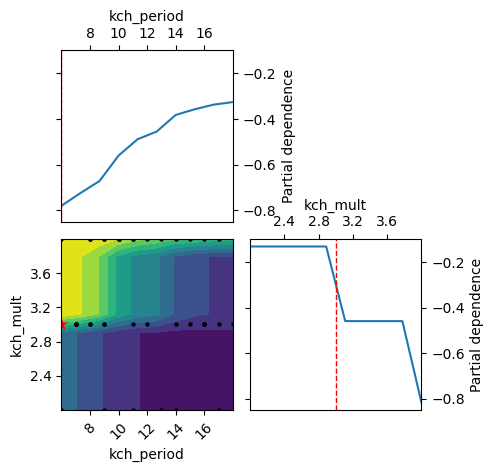

In [123]:
_ = plot_objective(optimize_result, n_points=10)

In [124]:
stats_sk

Start                     2023-01-01 00:00:00
End                       2023-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                    0.211792
Equity Final [$]                     1.010486
Equity Peak [$]                      1.022493
Return [%]                           1.048565
Buy & Hold Return [%]              -24.791857
Return (Ann.) [%]                    1.048565
Volatility (Ann.) [%]                4.309007
Sharpe Ratio                         0.243343
Sortino Ratio                        0.709691
Calmar Ratio                         0.331521
Max. Drawdown [%]                   -3.162894
Avg. Drawdown [%]                   -1.640113
Max. Drawdown Duration      271 days 23:30:00
Avg. Drawdown Duration      120 days 07:30:00
# Trades                                   20
Win Rate [%]                             25.0
Best Trade [%]                       3.574852
Worst Trade [%]                     -0.765064
Avg. Trade [%]                    

In [125]:
def save_stat(symbol, fitness, method, stat):
    stats_df = pd.DataFrame(stats.items(), columns=['Metric', 'Value'])
    print(stats)
    rows_to_exclude = ['_strategy', '_equity_curve', '_trades']
    stats_df = stats_df[~stats_df['Metric'].isin(rows_to_exclude)]
    symbol_method_df = pd.DataFrame({'Metric': ['Symbol', 'Target', 'Method'],
                                 'Value': [symbol, fitness, method]})
    print(symbol_method_df)
    stats_df = pd.concat([symbol_method_df, stats_df], ignore_index=True)
    pdf_file = symbol + '_' + fitness + '_' + method + '_optimization_stats.pdf'
    plt.figure(figsize=(10, 6))
    plt.table(cellText=stats_df.values,
              colLabels=stats_df.columns,
              loc='center')
    plt.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.savefig(pdf_file, format='pdf')
    return pdf_file

Start                     2023-01-01 00:00:00
End                       2023-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                    0.211792
Equity Final [$]                     1.010486
Equity Peak [$]                      1.022493
Return [%]                           1.048565
Buy & Hold Return [%]              -24.791857
Return (Ann.) [%]                    1.048565
Volatility (Ann.) [%]                4.309007
Sharpe Ratio                         0.243343
Sortino Ratio                        0.709691
Calmar Ratio                         0.331521
Max. Drawdown [%]                   -3.162894
Avg. Drawdown [%]                   -1.640113
Max. Drawdown Duration      271 days 23:30:00
Avg. Drawdown Duration      120 days 07:30:00
# Trades                                   20
Win Rate [%]                             25.0
Best Trade [%]                       3.574852
Worst Trade [%]                     -0.765064
Avg. Trade [%]                    

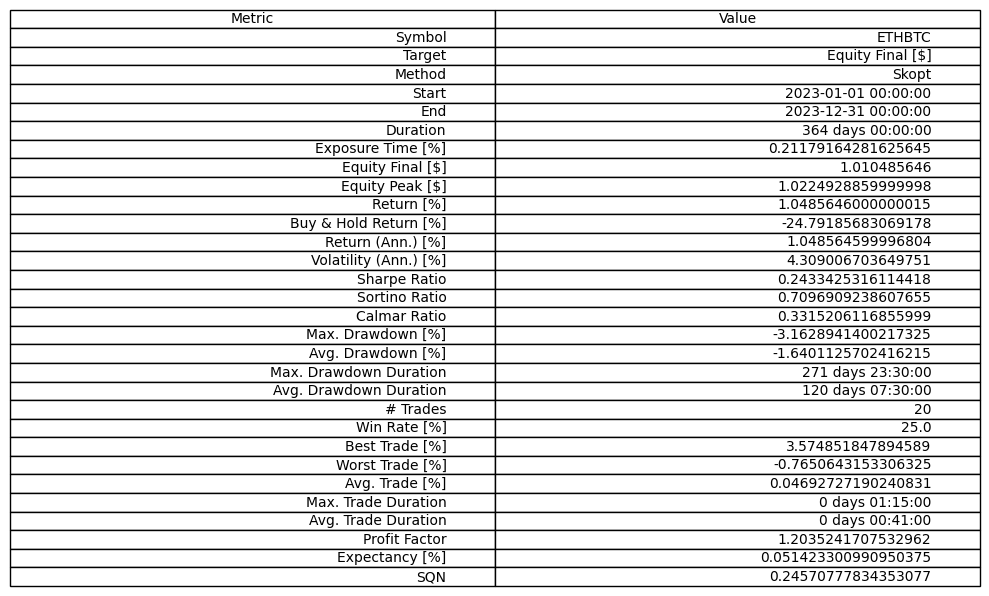

In [126]:
# Save the table to a PDF file
pdf_file = save_stat(symbol, fitness, method, stats_sk)

In [127]:
print(f"Optimization statistics saved to '{pdf_file}'")

Optimization statistics saved to 'ETHBTC_Equity Final [$]_Skopt_optimization_stats.pdf'
